In [7]:
import pandas as pd

# Load all four datasets with IPI predictions
datasets = {
    'BERTopic': '../data/processed/bertopic_with_ipi_preds.csv',
    'LDA': '../data/processed/lda_with_ipi_preds.csv',
    'sLDA': '../data/processed/slda_with_ipi_preds.csv',
    'TinyLLM': '../data/processed/tinyllm_with_ipi_preds.csv'
}

monthly_results = []

for source_name, file_path in datasets.items():
    # Load dataset
    df = pd.read_csv(file_path, parse_dates=['month'])
    selected = df[['month', 'IPI_predicted']]
    
    # Average IPI per month
    selected['month'] = selected['month'].dt.to_period('M').dt.to_timestamp()
    monthly = selected.groupby('month').mean(numeric_only=True).reset_index()
    monthly.rename(columns={'IPI_predicted': 'IPI_predicted_avg'}, inplace=True)
    
    # Add source column
    monthly['source'] = source_name
    monthly_results.append(monthly)

# Load actual IPI values
ipi_actual = pd.read_csv('../data/raw/INDPRO.csv', parse_dates=['observation_date'])
ipi_actual = ipi_actual[['observation_date', 'INDPRO']].copy()
ipi_actual.rename(columns={'observation_date': 'month'}, inplace=True)
ipi_actual['month'] = ipi_actual['month'].dt.to_period('M').dt.to_timestamp()
ipi_actual.rename(columns={'INDPRO': 'IPI_predicted_avg'}, inplace=True)
ipi_actual['source'] = 'Actual Values'

# Combine all results (predictions + actual)
all_monthly = pd.concat(monthly_results + [ipi_actual], ignore_index=True)

# Keep only months that are available for all prediction datasets
prediction_months = pd.concat(monthly_results, ignore_index=True)['month'].unique()
all_monthly = all_monthly[all_monthly['month'].isin(prediction_months)]

print(f"Combined {len(all_monthly)} monthly values from {len(datasets)+1} sources")
all_monthly.head()

Combined 260 monthly values from 5 sources


/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_9929/2698218427.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['month'] = selected['month'].dt.to_period('M').dt.to_timestamp()
/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_9929/2698218427.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  selected['month'] = selected['month'].dt.to_period('M').dt.to_timestamp()
/var/folders/j1/4lz7xm154pjbk8ddd_dk09b80000gn/T/ipykernel_9929/2698218427.py:19: SettingWithCopyWarning: 
A

,month,IPI_predicted_avg,source
0,2016-01-01,99.4391,BERTopic
1,2016-02-01,98.9232,BERTopic
2,2016-03-01,98.1635,BERTopic
3,2016-04-01,98.4775,BERTopic
4,2016-05-01,98.2549,BERTopic


In [8]:
# Display summary by source
print("Summary by source:")
print(all_monthly.groupby('source').agg({
    'month': ['min', 'max', 'count'],
    'IPI_predicted_avg': ['mean', 'std']
}))

Summary by source:
                   month                  IPI_predicted_avg          
                     min        max count              mean       std
source                                                               
Actual Values 2016-01-01 2020-04-01    52        100.705746  2.983973
BERTopic      2016-01-01 2020-04-01    52        101.026738  1.847759
LDA           2016-01-01 2020-04-01    52        101.069111  1.852052
TinyLLM       2016-01-01 2020-04-01    52        101.067375  1.860457
sLDA          2016-01-01 2020-04-01    52        100.952339  0.008802


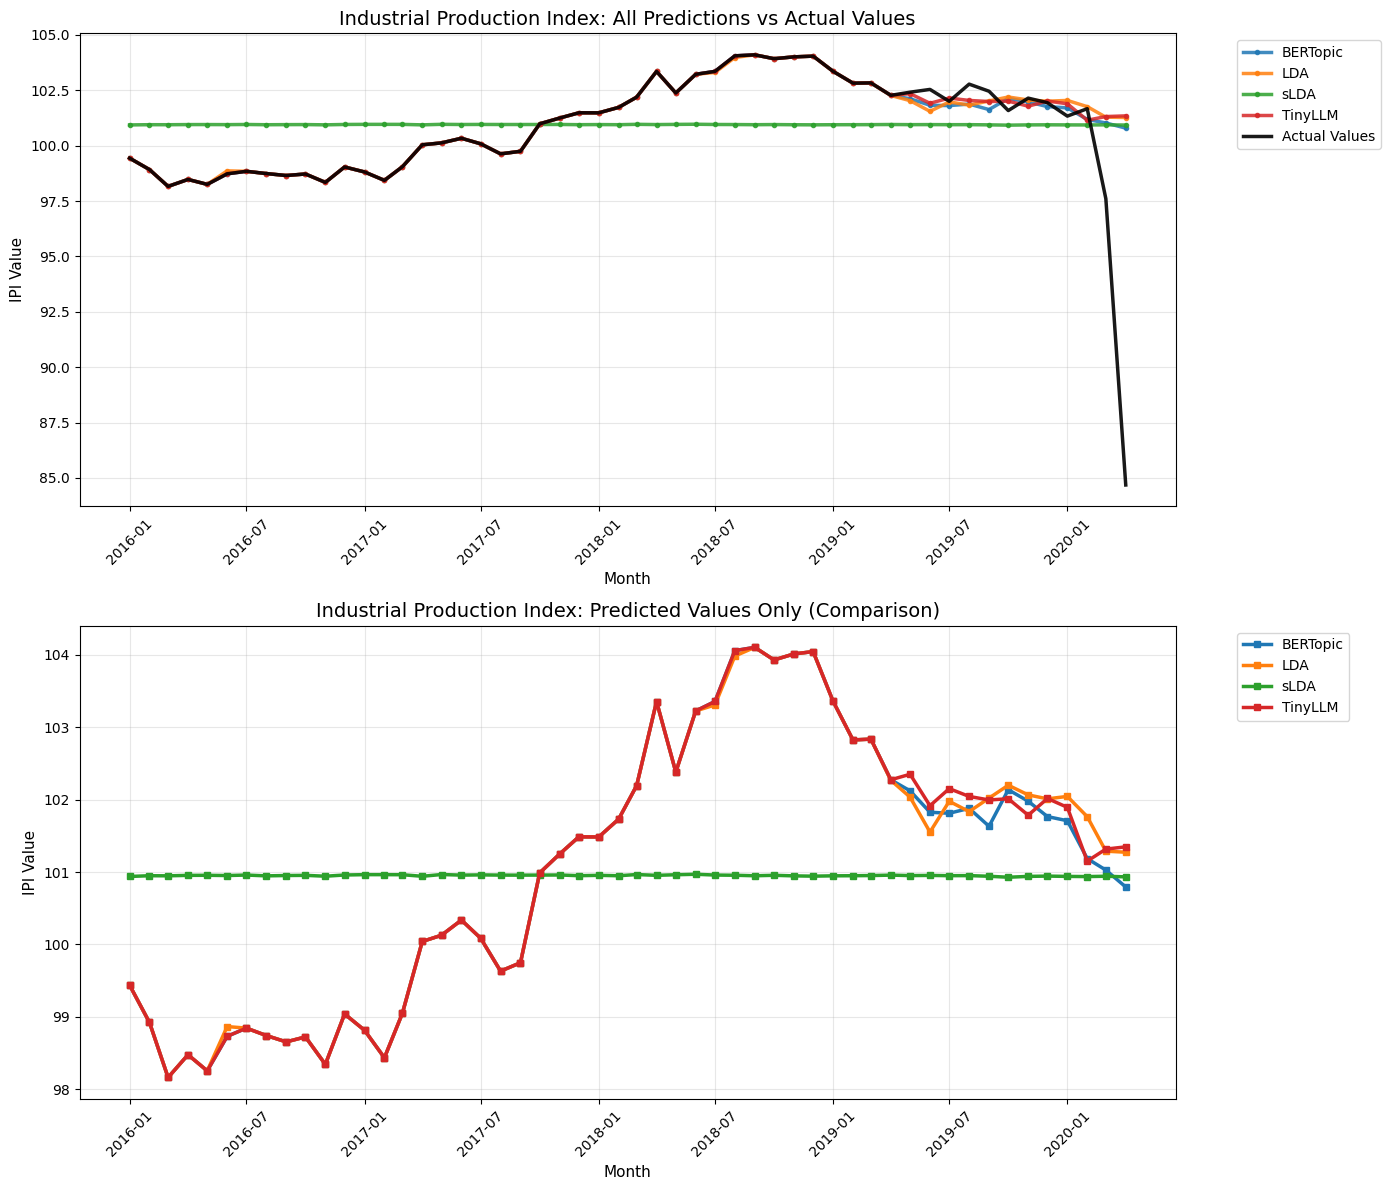


Correlation with Actual Values:
BERTopic: 0.6390
LDA: 0.6100
TinyLLM: 0.6071
sLDA: 0.1771


In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot predicted vs actual values over time
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 12))

# Set color palette
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
sources = all_monthly['source'].unique()

# Top plot: All lines together but with improved visibility
for i, source in enumerate(sources):
    data = all_monthly[all_monthly['source'] == source].sort_values('month')
    
    if source == 'Actual Values':
        ax1.plot(data['month'], data['IPI_predicted_avg'], 
                color='black', linewidth=2.5, label=source, linestyle='-', alpha=0.9)
    else:
        ax1.plot(data['month'], data['IPI_predicted_avg'], 
                color=colors[i], linewidth=2.5, label=source, linestyle='-', alpha=0.85, marker='o', markersize=3)

ax1.set_title('Industrial Production Index: All Predictions vs Actual Values', fontsize=14)
ax1.set_xlabel('Month', fontsize=11)
ax1.set_ylabel('IPI Value', fontsize=11)
ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Bottom plot: Predicted values only (without actual) for better comparison
prediction_sources = [s for s in sources if s != 'Actual Values']
for i, source in enumerate(prediction_sources):
    data = all_monthly[all_monthly['source'] == source].sort_values('month')
    ax2.plot(data['month'], data['IPI_predicted_avg'], 
            color=colors[i], linewidth=2.5, label=source, linestyle='-', marker='s', markersize=4)

ax2.set_title('Industrial Production Index: Predicted Values Only (Comparison)', fontsize=14)
ax2.set_xlabel('Month', fontsize=11)
ax2.set_ylabel('IPI Value', fontsize=11)
ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Calculate and display correlation with actual values
actual_data = all_monthly[all_monthly['source'] == 'Actual Values'][['month', 'IPI_predicted_avg']]
correlations = {}

for source in sources:
    if source != 'Actual Values':
        pred_data = all_monthly[all_monthly['source'] == source][['month', 'IPI_predicted_avg']]
        merged = actual_data.merge(pred_data, on='month', suffixes=('_actual', '_pred'))
        corr = merged['IPI_predicted_avg_actual'].corr(merged['IPI_predicted_avg_pred'])
        correlations[source] = corr

print("\nCorrelation with Actual Values:")
for source, corr in sorted(correlations.items(), key=lambda x: x[1], reverse=True):
    print(f"{source}: {corr:.4f}")